In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google_drive_downloader import GoogleDriveDownloader as gdd 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
gdd.download_file_from_google_drive(file_id = '1p4azCzZlFR5KZNVa4bG-LrZZtx0lPds1', dest_path = '/hour.csv')

In [ ]:
df = pd.read_csv('/hour.csv')

In [ ]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


###EDA and Preprocessing


In [ ]:
scale = StandardScaler()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
df.rename(columns = {"cnt":"target"}, inplace = True)

In [ ]:
#That's awesome how clear this dataset
#Well, I think in the real world it is unreal to find such clear data
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
target        0
dtype: int64

In [ ]:
df['dteday'] = pd.to_datetime(df['dteday'])
df = df.set_index(df['dteday'])

In [ ]:
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
#season column doesn't match actual seasons. I would use mnth value instead. 
#Maybe the problem with season is due to the fact that the data was collected in Washington
#Also instant column is just indexing
df.drop(columns = ['dteday', 'season', 'instant'], inplace = True)

In [ ]:
df.head()

,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,target,day_of_month,day_of_week
0,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,5
1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,5
2,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1,5
3,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1,5
4,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1,5


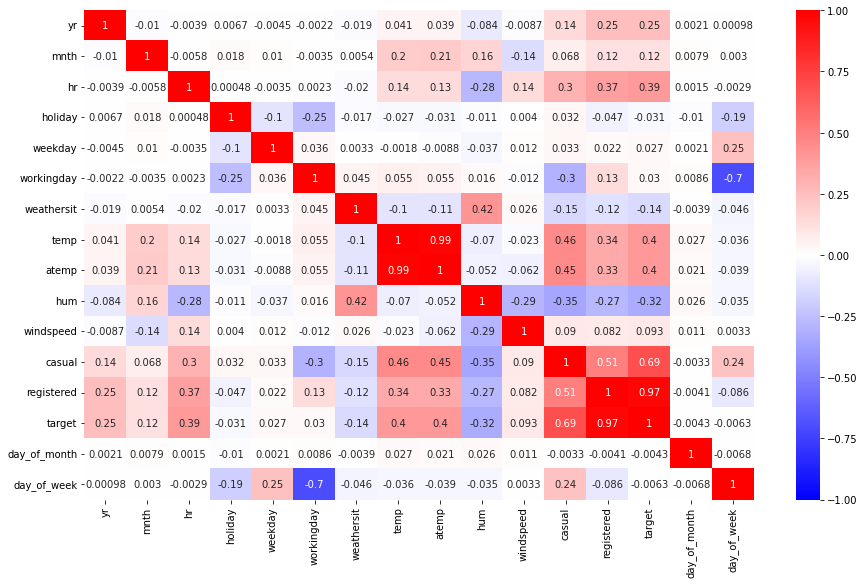

In [ ]:
#We can see that target is highly correlated with registered, casual, temp, atemp, hr, hum and year
#Later I'll train models using temp and atemp features to see what works best
f, ax = plt.subplots(figsize = (15, 9))
sns.heatmap(df.corr(), vmin = -1, vmax = 1, cmap = 'bwr', annot = True)
plt.show()

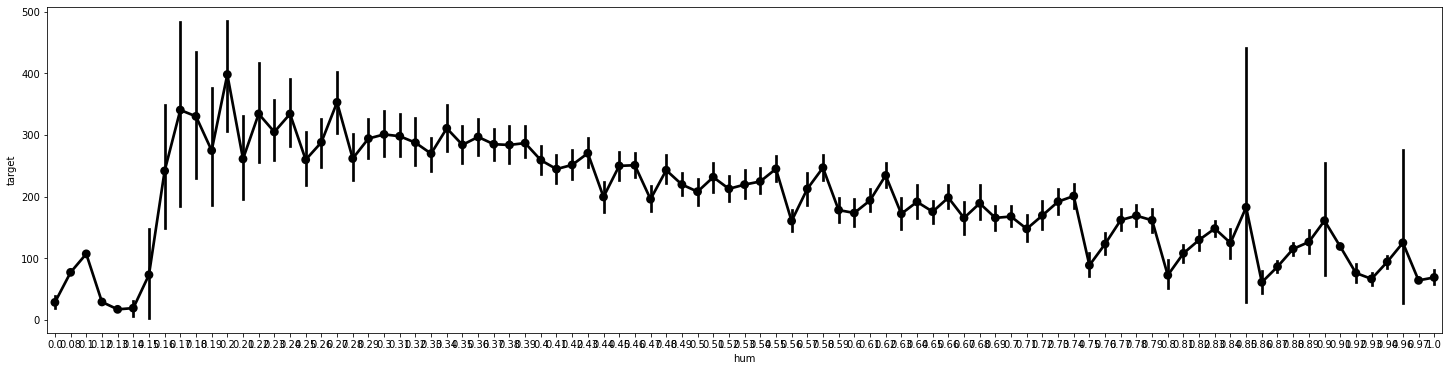

In [ ]:
plt.figure(figsize=(25,6))
sns.pointplot(data = df,x=df.hum,y=df.target,color='black')

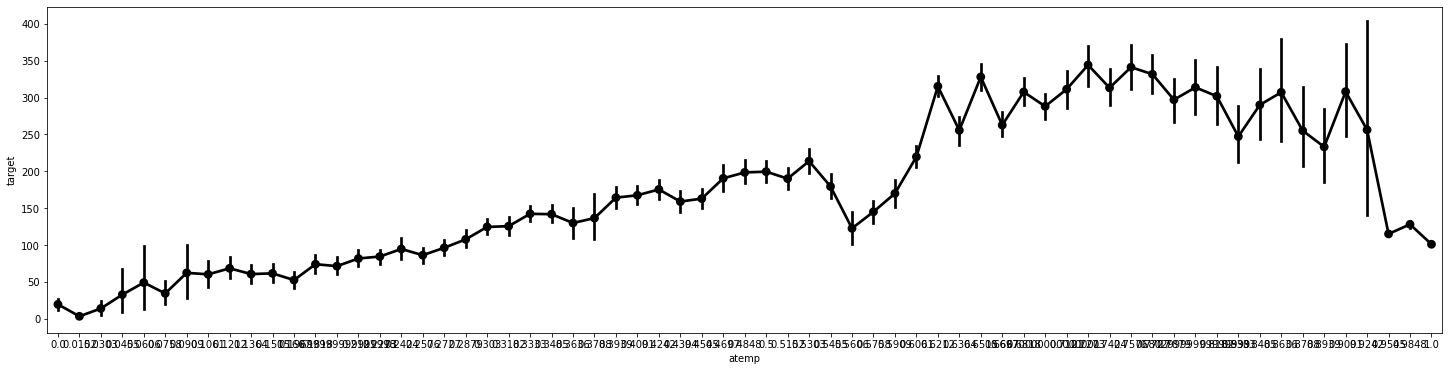

In [ ]:
plt.figure(figsize=(25,6))
sns.pointplot(data = df,x=df.atemp,y=df.target,color='black')

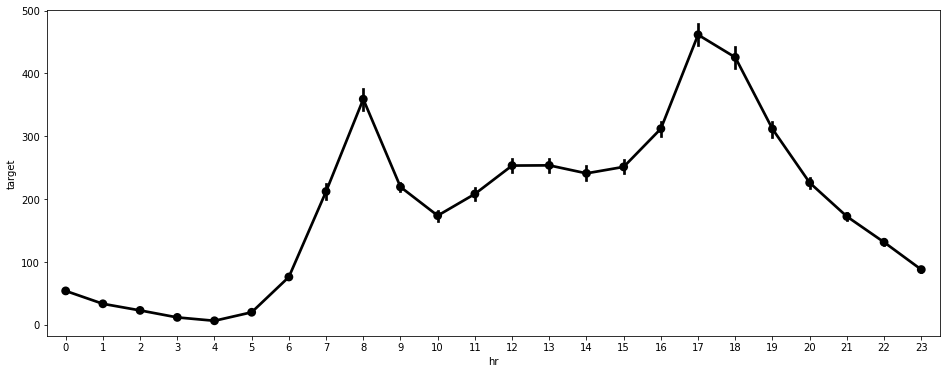

In [ ]:
#Here we can say that between 16 to 19 o'clock the demand is on peak
plt.figure(figsize=(16,6))
sns.pointplot(data = df,x=df.hr,y=df.target,color='black')

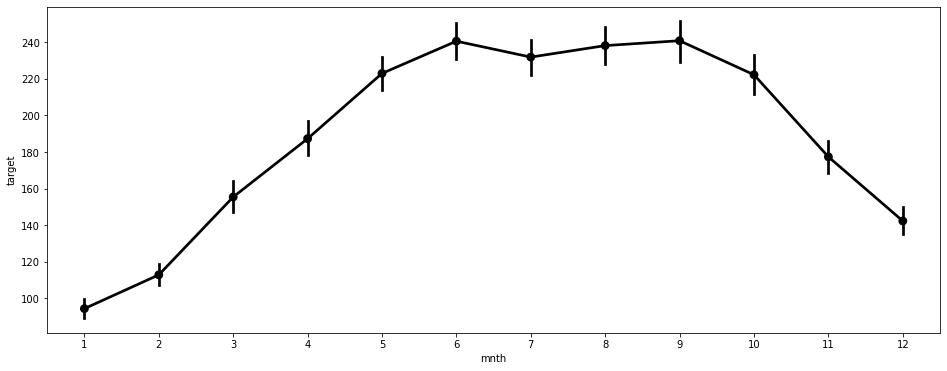

In [ ]:
#Well, the demand is on peak in summer then starting to decrease 
plt.figure(figsize = (16, 6))
sns.pointplot(data = df, x = df.mnth, y = df.target, color = 'black')

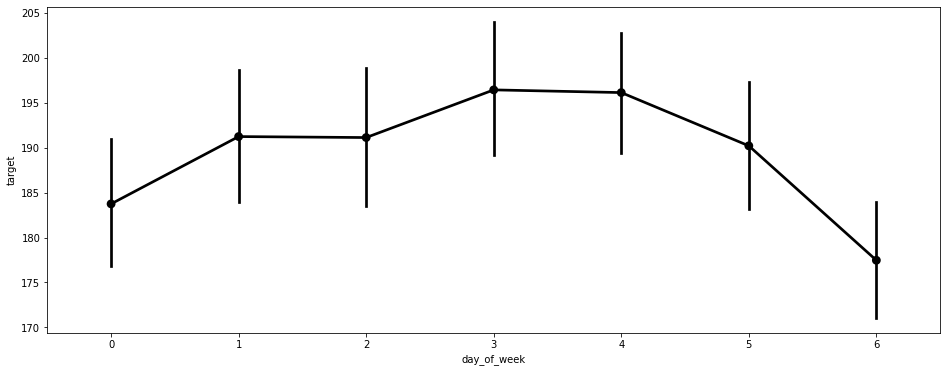

In [ ]:
#Least demand is on weekend 
plt.figure(figsize = (16, 6))
sns.pointplot(data = df, x = df.day_of_week, y = df.target, color = 'black')

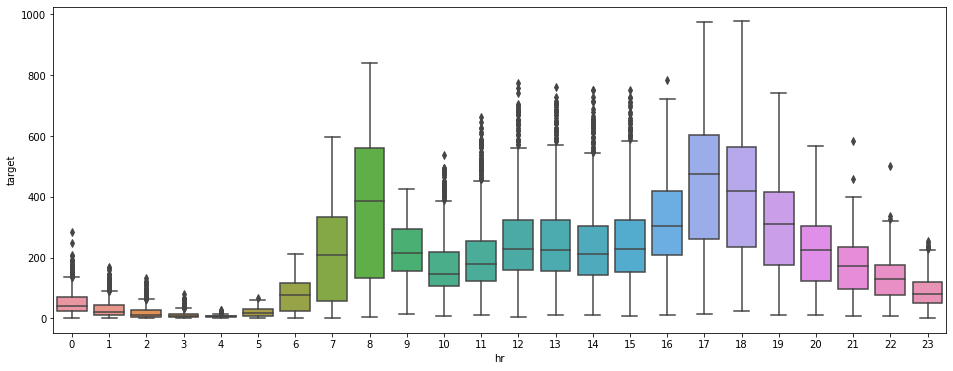

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(data = df,x = df["hr"],y = df.target)

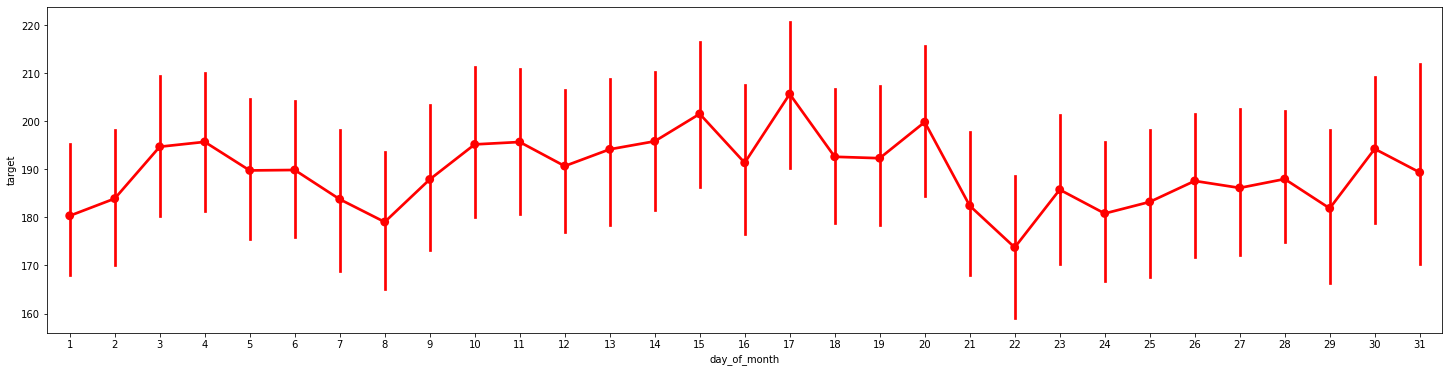

In [ ]:
#The demand doesn't differ on day of month 
plt.figure(figsize=(25,6))
sns.pointplot(data = df, x = df.day_of_month, y = df.target, color = 'red')

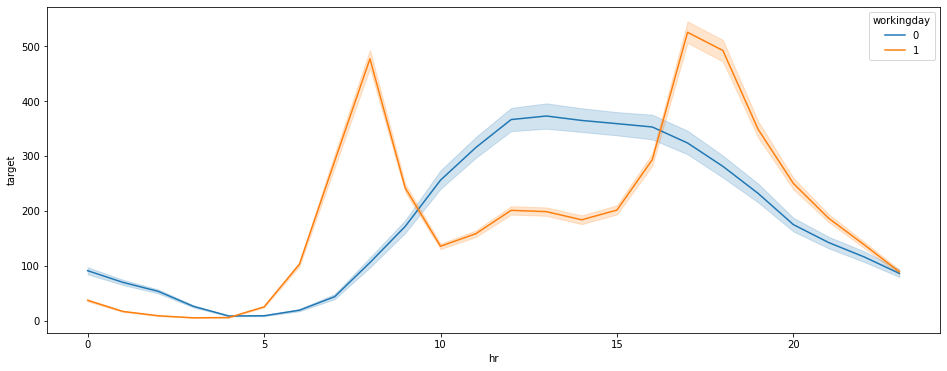

In [ ]:
#Here we can see how demand depends on hours, whether it is working day or not
plt.figure(figsize=(16,6))
sns.lineplot(x=df.hr,y=df.target,data=df,hue=df.workingday)

In [ ]:
df_without_atemp = df.drop(columns = ['atemp'])

In [ ]:
df_without_atemp.columns

Index(['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'casual', 'registered', 'target',
       'day_of_month', 'day_of_week'],
      dtype='object')

In [ ]:
df_without_atemp['mnth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
df_without_atemp_encoded = df_without_atemp.copy()
df_without_atemp_encoded['mnth'].replace({1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}, inplace = True)

In [ ]:
df_without_atemp_encoded['mnth'].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [ ]:
months = pd.get_dummies(df_without_atemp_encoded.mnth)
df_without_atemp_encoded = pd.concat([df_without_atemp_encoded, months], axis = 1)
df_without_atemp_encoded.drop(columns = ['mnth'], inplace = True)

In [ ]:
df_without_atemp_encoded['day_of_week'].replace({6 : 'Sun', 0 : 'Mon', 1 : 'Tue', 2 : 'Wed', 3 : 'Thu', 4 : 'Fri', 5 : 'Sat'}, inplace = True)

weekdays = pd.get_dummies(df_without_atemp_encoded.day_of_week)
df_without_atemp_encoded = pd.concat([df_without_atemp_encoded, weekdays], axis = 1)
df_without_atemp_encoded.drop(columns = ['weekday', 'day_of_week'], inplace = True)

In [ ]:
df_without_atemp_encoded.head()

,yr,hr,holiday,workingday,weathersit,temp,hum,windspeed,casual,registered,target,day_of_month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,0,0,1,0.24,0.81,0.0,3,13,16,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,1,0.22,0.80,0.0,8,32,40,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,2,0,0,1,0.22,0.80,0.0,5,27,32,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,3,0,0,1,0.24,0.75,0.0,3,10,13,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,4,0,0,1,0.24,0.75,0.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
#Same preprocessing for dataframe without temp 
df_without_temp = df.drop(columns = ['temp'])

In [ ]:
df_without_temp_encoded = df_without_temp.copy()
df_without_temp_encoded['mnth'].replace({1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}, inplace = True)

In [ ]:
months = pd.get_dummies(df_without_temp_encoded.mnth)
df_without_temp_encoded = pd.concat([df_without_temp_encoded, months], axis = 1)
df_without_temp_encoded.drop(columns = ['mnth'], inplace = True)

In [ ]:
df_without_temp_encoded['day_of_week'].replace({6 : 'Sun', 0 : 'Mon', 1 : 'Tue', 2 : 'Wed', 3 : 'Thu', 4 : 'Fri', 5 : 'Sat'}, inplace = True)

weekdays = pd.get_dummies(df_without_temp_encoded.day_of_week)
df_without_temp_encoded = pd.concat([df_without_temp_encoded, weekdays], axis = 1)
df_without_temp_encoded.drop(columns = ['weekday', 'day_of_week'], inplace = True)

In [ ]:
df_without_temp_encoded.head()

,yr,hr,holiday,workingday,weathersit,atemp,hum,windspeed,casual,registered,target,day_of_month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,0,0,1,0.2879,0.81,0.0,3,13,16,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,1,0.2727,0.80,0.0,8,32,40,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,2,0,0,1,0.2727,0.80,0.0,5,27,32,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,3,0,0,1,0.2879,0.75,0.0,3,10,13,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,4,0,0,1,0.2879,0.75,0.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Models

## KNR


In [ ]:
X = df_without_atemp_encoded.drop(['target'], axis = 1)
y = df_without_atemp_encoded.target

In [ ]:
X = scale.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#K-Nearest Regressor (temp)
knr = GridSearchCV(KNeighborsRegressor(), {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 5 ,7, 9],
    'metric': ['manhattan', 'minkowski', 'euclidean']
}, cv = 5, return_train_score = False)

knr.fit(X_train, y_train)

knr_results_df = pd.DataFrame(knr.cv_results_)

In [ ]:
y_pred_knr_temp = knr.predict(X_test)

In [ ]:
knr_results_df[['param_weights', 'param_n_neighbors', 'param_metric', 'mean_test_score']].head()

,param_weights,param_n_neighbors,param_metric,mean_test_score
0,uniform,3,manhattan,0.851613
1,distance,3,manhattan,0.868909
2,uniform,5,manhattan,0.840744
3,distance,5,manhattan,0.866527
4,uniform,7,manhattan,0.827937


In [ ]:
print(f'R2 score: {r2_score(y_pred_knr_temp, y_test)}')

R2 score: 0.8873057645293776


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_knr_temp))

Mean absolute score (MAE): 38.46


In [ ]:
X = df_without_temp_encoded.drop(['target'], axis = 1)
y = df_without_temp_encoded.target

In [ ]:
X = scale.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#K-Nearest Regressor (atemp)
knr = GridSearchCV(KNeighborsRegressor(), {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 5 ,7, 9],
    'metric': ['manhattan', 'minkowski', 'euclidean']
}, cv = 5, return_train_score = False)

knr.fit(X_train, y_train)

knr_results_df_2 = pd.DataFrame(knr.cv_results_)

In [ ]:
y_pred_knr_atemp = knr.predict(X_test)

In [ ]:
knr_results_df_2[['param_weights', 'param_n_neighbors', 'param_metric', 'mean_test_score']].head()

,param_weights,param_n_neighbors,param_metric,mean_test_score
0,uniform,3,manhattan,0.856172
1,distance,3,manhattan,0.872147
2,uniform,5,manhattan,0.843012
3,distance,5,manhattan,0.867595
4,uniform,7,manhattan,0.831114


In [ ]:
print(f'R2 score: {r2_score(y_pred_knr_atemp, y_test)}')

R2 score: 0.889171124517393


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_knr_atemp))

Mean absolute score (MAE): 38.29


Well, knr performed very well. MAE score is good for both classifiers

## Decision Tree Regressor

In [ ]:
X = df_without_atemp.drop(['target'], axis = 1)
y = df_without_atemp.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#Decision Tree Regressor (temp)
dtr_temp = GridSearchCV(DecisionTreeRegressor(),{
    'max_depth': [3, 7, 15],
    'min_samples_split': [0.2, 0.5, 1, 2],
    'min_samples_leaf':[0.1, 0.5, 2],
    'max_features': ['sqrt', 'log2', 'auto']
}, cv = 5, return_train_score = False)

dtr_temp.fit(X_train, y_train)
pd.DataFrame(dtr_temp.cv_results_)[['param_max_depth','param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'mean_test_score']].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score
0,3,0.2,0.1,sqrt,0.545489
1,3,0.5,0.1,sqrt,0.637057
2,3,1,0.1,sqrt,NaN
3,3,2,0.1,sqrt,0.596931
4,3,0.2,0.5,sqrt,-0.000528


In [ ]:
y_pred_dtr_temp = dtr_temp.predict(X_test)

In [ ]:
print(f'R2 score: {r2_score(y_pred_dtr_temp, y_test)}')

R2 score: 0.9992432636873388


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_dtr_temp))

Mean absolute score (MAE): 2.43


In [ ]:
X = df_without_temp.drop(['target'], axis = 1)
y = df_without_temp.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#Decision Tree Regressor (atemp)
dtr_atemp = GridSearchCV(DecisionTreeRegressor(),{
    'max_depth': [3, 7, 15],
    'min_samples_split': [0.2, 0.5, 1, 2],
    'min_samples_leaf':[0.1, 0.5, 2],
    'max_features': ['sqrt', 'log2', 'auto']
}, cv = 5, return_train_score = False)

dtr_atemp.fit(X_train, y_train)
pd.DataFrame(dtr_atemp.cv_results_)[['param_max_depth','param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'mean_test_score']].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score
0,3,0.2,0.1,sqrt,0.569900
1,3,0.5,0.1,sqrt,0.540517
2,3,1,0.1,sqrt,NaN
3,3,2,0.1,sqrt,0.675447
4,3,0.2,0.5,sqrt,-0.000545


In [ ]:
y_pred_dtr_atemp = dtr_atemp.predict(X_test)

In [ ]:
print(f'R2 score: {r2_score(y_pred_dtr_atemp, y_test)}')

R2 score: 0.9992492711861036


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_dtr_atemp))

Mean absolute score (MAE): 2.40


The results for Decision Tree Regressor impress me

## Random Forest

In [ ]:
X = df_without_atemp.drop(['target'], axis = 1)
y = df_without_atemp.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#Random Forest (temp)

rf_temp = RandomizedSearchCV(RandomForestRegressor(), {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}, cv = 3, n_jobs = -1, verbose = 2)

rf_temp.fit(X_train, y_train)
pd.DataFrame(rf_temp.cv_results_)[['param_bootstrap', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 
                                   'param_min_samples_split', 'param_n_estimators', 'mean_test_score']].head()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,100,3,3,8,100,0.992134
1,True,80,3,5,12,100,0.989584
2,True,100,2,3,12,300,0.975678
3,True,110,3,4,8,1000,0.991876
4,True,90,2,5,8,100,0.973678


In [ ]:
y_pred_rf_temp = rf_temp.predict(X_test)

In [ ]:
print(f'R2 score: {r2_score(y_pred_rf_temp, y_test)}')

R2 score: 0.9948803936725028


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_rf_temp))

Mean absolute score (MAE): 7.32


In [ ]:
X = df_without_temp.drop(['target'], axis = 1)
y = df_without_temp.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#Random Forest (atemp)

rf_atemp = RandomizedSearchCV(RandomForestRegressor(), {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}, cv = 3, n_jobs = -1, verbose = 2)

rf_atemp.fit(X_train, y_train)
pd.DataFrame(rf_atemp.cv_results_)[['param_bootstrap', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 
                                    'param_min_samples_split', 'param_n_estimators', 'mean_test_score']].head()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,110,3,4,12,300,0.990417
1,True,90,2,4,8,200,0.976574
2,True,80,3,5,10,1000,0.991028
3,True,100,2,3,8,200,0.978813
4,True,110,2,3,12,100,0.973622


In [ ]:
y_pred_rf_atemp = rf_atemp.predict(X_test) 

In [ ]:
print(f'R2 score: {r2_score(y_pred_rf_atemp, y_test)}')

R2 score: 0.9918701662778985


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_rf_atemp))

Mean absolute score (MAE): 8.31


Random Forest performed a little bit worse than Decision Tree. I think it is because was used Random instead of Grid search 

## SVM Regressor

In [ ]:
X = df_without_atemp_encoded.drop(['target'], axis = 1)
y = df_without_atemp_encoded.target

In [ ]:
X = scale.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#SVR (temp)
svr_temp = RandomizedSearchCV(SVR(), {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 0.1, 0.01, 0.001, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}, cv = 3, refit=True, verbose=2)

svr_temp.fit(X_train, y_train)

In [ ]:
svr_temp.best_estimator_

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
pd.DataFrame(svr_temp.cv_results_)[['param_kernel', 'param_C', 'param_gamma','mean_test_score']].head()

,param_kernel,param_C,param_gamma,mean_test_score
0,poly,1,0.01,-0.041199
1,rbf,0.1,1,-0.067532
2,sigmoid,100,0.001,1.000000
3,poly,0.1,0.001,-0.068212
4,poly,10,0.1,1.000000


In [ ]:
y_pred_svr_temp = svr_temp.predict(X_test)

In [ ]:
print(f'R2 score: {r2_score(y_pred_svr_temp, y_test)}')

R2 score: 0.9999998994175243


In [ ]:
print(f'Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_svr_temp))

Mean absolute score (MAE): 0.05


In [ ]:
X = df_without_temp_encoded.drop(['target'], axis = 1)
y = df_without_temp_encoded.target

In [ ]:
X = scale.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#SVR (atemp)
svr_atemp = RandomizedSearchCV(SVR(), {
     'kernel': ['linear', 'poly', 'sigmoid'],
    'C': [1, 0.1, 0.01],
    'gamma': [1, 0.01, 0.001]
}, cv = 2, refit=True, verbose=2)

svr_atemp.fit(X_train, y_train)
pd.DataFrame(svr_atemp.cv_results_)[['param_kernel', 'param_C', 'param_gamma','mean_test_score']].head()

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] kernel=poly, gamma=0.001, C=1 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... kernel=poly, gamma=0.001, C=1, total=   5.1s
[CV] kernel=poly, gamma=0.001, C=1 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] .................... kernel=poly, gamma=0.001, C=1, total=   4.9s
[CV] kernel=sigmoid, gamma=1, C=0.01 .................................
[CV] .................. kernel=sigmoid, gamma=1, C=0.01, total=   8.3s
[CV] kernel=sigmoid, gamma=1, C=0.01 .................................
[CV] .................. kernel=sigmoid, gamma=1, C=0.01, total=   8.3s
[CV] kernel=sigmoid, gamma=0.001, C=0.01 .............................
[CV] .............. kernel=sigmoid, gamma=0.001, C=0.01, total=   7.2s
[CV] kernel=sigmoid, gamma=0.001, C=0.01 .............................
[CV] .............. kernel=sigmoid, gamma=0.001, C=0.01, total=   7.2s
[CV] kernel=sigmoid, gamma=0.001, C=1 ................................
[CV] ................. kernel=sigmoid, gamma=0.001, C=1, total=   7.2s
[CV] kernel=sigmoid, gamma=0.001, C=1 ................................
[CV] ................. kernel=sigmoid, gamma=0.001, C=1, total=   7.2s
[CV] kernel=poly, gamma=1, C=0.01 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 45.0min finished


,param_kernel,param_C,param_gamma,mean_test_score
0,poly,1,0.001,-0.067918
1,sigmoid,0.01,1,0.078601
2,sigmoid,0.01,0.001,-0.066750
3,sigmoid,1,0.001,0.049809
4,poly,0.01,1,0.999999


In [ ]:
y_pred_svr_atemp = svr_atemp.predict(X_test)

In [ ]:
print(f'R2 score: {r2_score(y_pred_svr_atemp, y_test)}')

R2 score: 0.9999998915795477


In [ ]:
print(f'Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_svr_atemp))

Mean absolute score (MAE): 0.05


SVR performed fantastic

## AdaBoostRegressor

In [ ]:
X = df_without_atemp.drop(['target'], axis = 1)
y = df_without_atemp.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#AdaBoostRegressor (temp)
abr_temp = RandomizedSearchCV(AdaBoostRegressor(),{
     'n_estimators': [50, 100],
     'learning_rate' : [0.01,0.05,0.1,0.3,1],
     'loss' : ['linear', 'square', 'exponential']
}, cv = 3, n_iter = 10, n_jobs = -1, return_train_score = False)

abr_temp.fit(X_train, y_train)
pd.DataFrame(abr_temp.cv_results_)[['param_n_estimators','param_learning_rate', 'param_loss']].head()

,param_n_estimators,param_learning_rate,param_loss
0,50,0.01,linear
1,50,0.05,square
2,100,0.01,exponential
3,100,1,square
4,100,0.01,square


In [ ]:
y_pred_abr_temp = abr_temp.predict(X_test)

In [ ]:
print(f'R2 score: {r2_score(y_pred_abr_temp, y_test)}')

R2 score: 0.9811452414925871


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_abr_temp))

Mean absolute score (MAE): 19.25


In [ ]:
X = df_without_temp.drop(['target'], axis = 1)
y = df_without_temp.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#AdaBoostRegressor (atemp)
abr_atemp = RandomizedSearchCV(AdaBoostRegressor(),{
     'n_estimators': [50, 100],
     'learning_rate' : [0.01,0.05,0.1,0.3,1],
     'loss' : ['linear', 'square', 'exponential']
}, cv = 3, n_iter = 10, n_jobs = -1, return_train_score = False)

abr_atemp.fit(X_train, y_train)
pd.DataFrame(abr_atemp.cv_results_)[['param_n_estimators','param_learning_rate', 'param_loss']].head()

,param_n_estimators,param_learning_rate,param_loss
0,100,0.3,square
1,100,0.1,exponential
2,100,0.05,exponential
3,100,1,square
4,100,0.1,square


In [ ]:
y_pred_abr_atemp = abr_atemp.predict(X_test)

In [ ]:
print(f'R2 score: {r2_score(y_pred_abr_atemp, y_test)}')

R2 score: 0.9793842947175593


In [ ]:
print('Mean absolute score (MAE): %.2f'%mean_absolute_error(y_test, y_pred_abr_atemp))

Mean absolute score (MAE): 20.31


Not the best, but great results for adaboost

## Conclusion

* The best model is SVR with MAE score 0.05
* Current hour is more important, because even if it's not the greatest season, demand is on peak or at the bottom, whether it's 5pm or 2am for example. And the season plot is more monotonous
* Well, I can say that feeling temperature is more important, because demand depends on how people feel temperature not on the actual value of it
* I don't think the humidity is affect the target very strong, but there is a decreasing trend in it's plot, which means more hum - less demand
* The most affectable features are registered, casual, atemp

In [ ]:
lst = [1, 5, 3, 1, 4, 8, 9, 2, 4]

In [ ]:
k = 3

In [ ]:
for i in range(len(lst)) - 1:
  for j in range(len(lst)):
    if lst[i] == lst[j]:
     print(True)
